In [52]:
import pandas as pd
from datetime import datetime
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [53]:
# function to read inputs and merge
def data_read():
    iata = pd.read_csv('../data/iata_1_1.csv')
    events = pd.read_csv('../data/events_1_1.csv.gz')
    merged_data = events.merge(iata,left_on='origin',right_on='iata_code').drop('iata_code',axis=1)
    merged_data = merged_data.rename(columns={'lat':'origin_lat','lon':'origin_lon'})
    merged_data = merged_data.merge(iata,left_on='destination',right_on='iata_code').drop('iata_code',axis=1)
    merged_data = merged_data.rename(columns={'lat':'destination_lat','lon':'destination_lon'})
    return merged_data

In [54]:
#read input
booking_data = data_read()

In [111]:
booking_data.dtypes

ts                  object
event_type          object
user_id             object
date_from           object
date_to             object
origin              object
destination         object
num_adults           int64
num_children         int64
origin_lat         float64
origin_lon         float64
destination_lat    float64
destination_lon    float64
dtype: object

In [55]:
#check for NaN/NULL values
booking_data.isnull().sum()

ts                  0
event_type          0
user_id             0
date_from          84
date_to            12
origin              0
destination         0
num_adults          0
num_children        0
origin_lat          0
origin_lon          0
destination_lat     0
destination_lon     0
dtype: int64

In [56]:
#drop all NULL value records since it is not high in number
booking_data = booking_data.dropna()

In [57]:
#function to calculate the geo-distance between 2 lat-lon co-ordinates
def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [58]:
#calculate geo_distance and assign as a new column
booking_data['geo_distance(km)'] = haversine_vectorize(booking_data['origin_lon'],booking_data['origin_lat'],booking_data['destination_lon'],booking_data['destination_lat'])

In [62]:
booking_data['origin'].value_counts().count()

236

In [63]:
# This method is responsible to calculate the number of days between 2 dates.
def no_of_days(date_from,looking_on):
    date_format = "%Y-%m-%d"
    a = datetime.strptime(looking_on, date_format)
    b = datetime.strptime(date_from, date_format)
    delta = b - a #days
    return delta.days

In [64]:
# This feature 'days_before_plan' will be used to calculate the no of days before the user is planning to book/search for a flight.
booking_data['look_on']=booking_data['ts'].str.split(" ", n = 1, expand = True)[0]        
booking_data['days_before_plan'] = booking_data.apply(lambda row : no_of_days(row['date_from'], row['look_on']), axis = 1)

In [65]:
# This feature 'trip_duration' represents for how many days the trip was planned for
booking_data['trip_duration'] = booking_data.apply(lambda row : no_of_days(row['date_to'], row['date_from']), axis = 1)

In [83]:
booking_data.head()

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,origin_lat,...,geo_distance(km),look_on,days_before_plan,trip_duration,activity_month,travel_start_month,activity_hour,origin_enc,destination_enc,event_type_enc
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1,48.85,...,5834.154716,2017-04-27,35,6,4,6,11,166,178,1
1,2017-04-29 21:24:06,search,b32ef3,2017-05-02,2017-05-08,PAR,NYC,1,0,48.85,...,5834.154716,2017-04-29,3,6,4,5,21,166,178,1
2,2017-04-27 21:14:19,search,565d54,2017-06-01,2017-06-18,PAR,NYC,3,1,48.85,...,5834.154716,2017-04-27,35,17,4,6,21,166,178,1
3,2017-04-21 11:50:02,search,6d7b79,2017-08-23,2017-09-13,PAR,NYC,2,2,48.85,...,5834.154716,2017-04-21,124,21,4,8,11,166,178,1
4,2017-04-21 18:05:01,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1,48.85,...,5834.154716,2017-04-21,41,6,4,6,18,166,178,1


In [66]:
#Extract search/book activity month and hour, travel start date month as these features might give an indication of seasonality to the model
booking_data['activity_month'] = pd.to_datetime(booking_data['ts']).dt.month
booking_data['travel_start_month'] = pd.to_datetime(booking_data['date_from']).dt.month
booking_data['activity_hour'] = pd.to_datetime(booking_data['ts']).dt.hour

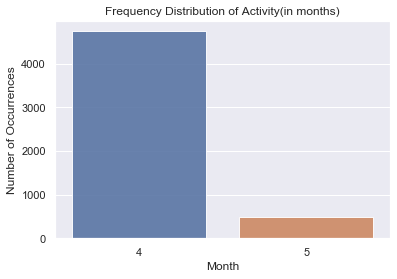

In [87]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
activity_book = booking_data.loc[booking_data['event_type'] == 'book','activity_month'].value_counts()
sns.set(style="darkgrid")
sns.barplot(activity_book.index, activity_book.values, alpha=0.9)
plt.title('Frequency Distribution of Activity(in months)')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

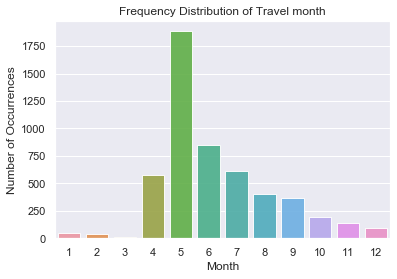

In [86]:
travel = booking_data.loc[booking_data['event_type'] == 'book','travel_start_month'].value_counts()
sns.set(style="darkgrid")
sns.barplot(travel.index, travel.values, alpha=0.9)
plt.title('Frequency Distribution of Travel month')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.show()

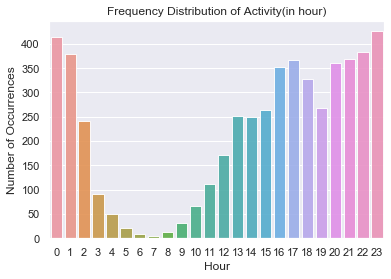

In [79]:
travel = booking_data.loc[booking_data['event_type'] == 'book','activity_hour'].value_counts()
sns.set(style="darkgrid")
sns.barplot(travel.index, travel.values, alpha=0.9)
plt.title('Frequency Distribution of Activity(in hour)')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Hour', fontsize=12)
plt.show()

In [18]:
# Encoding origin column
le = LabelEncoder()
le.fit(booking_data['origin'])
origin_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
booking_data['origin_enc'] = le.transform(booking_data['origin'])

#Encoding destination column
le = LabelEncoder()
le.fit(booking_data['destination'])
destination_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
booking_data['destination_enc'] = le.transform(booking_data['destination'])
        
# Encoding our label column i.e 'event_type'
le = LabelEncoder()
le.fit(booking_data['event_type'])
event_type_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
booking_data['event_type_enc'] = le.transform(booking_data['event_type'])

In [19]:
# Removing unwanted columns
booking_data.drop(['date_from','date_to','look_on','origin','destination','event_type','ts','user_id','origin_lat','origin_lon','destination_lat','destination_lon'],axis=1,inplace=True)

In [85]:
booking_data.head()

,num_adults,num_children,geo_distance(km),days_before_plan,trip_duration,activity_month,travel_start_month,activity_hour,origin_enc,destination_enc,event_type_enc
0,6,1,5834.154716,35,6,4,6,11,166,178,1
1,1,0,5834.154716,3,6,4,5,21,166,178,1
2,3,1,5834.154716,35,17,4,6,21,166,178,1
3,2,2,5834.154716,124,21,4,8,11,166,178,1
4,6,1,5834.154716,41,6,4,6,18,166,178,1


In [20]:
#remove records where 'days_before_plan' is negative as it is meaningless
booking_data = booking_data.loc[booking_data['days_before_plan'] > 0]

Text(0, 0.5, 'Frequency')

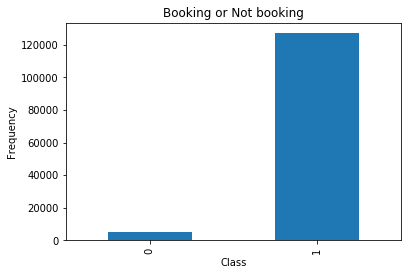

In [29]:
#check the distribution of search and book in event_type column
count_classes = pd.value_counts(booking_data['event_type_enc'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Booking or Not booking")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [40]:
#split the dataset into independant and dependant features for model training and validation
X = booking_data.loc[:, booking_data.columns != 'event_type_enc']
y = booking_data.loc[:, booking_data.columns == 'event_type_enc']

In [145]:
X.dtypes

num_adults              int64
num_children            int64
geo_distance(km)      float64
days_before_plan        int64
trip_duration           int64
activity_month          int64
travel_start_month      int64
activity_hour           int64
origin_enc              int32
destination_enc         int32
dtype: object

In [41]:
# Feature selection using chi-squared method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

In [42]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 8.187932
Feature 1: 14.395242
Feature 2: 746511.368741
Feature 3: 10068.594753
Feature 4: 1756.187181
Feature 5: 0.001288
Feature 6: 51.755570
Feature 7: 3.447784
Feature 8: 566.877852
Feature 9: 46.678883


In [49]:
# Handling unbalanced dataset with SMOTE oversampling technique
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [50]:
# fit a lightGBM classifier model to the data
# Why LightGBM? - It works great with categorical features
# categorical_feature = ['activity_month','origin_enc','destination_enc','travel_start_month','activity_hour']
model = lgb.LGBMClassifier(loss_function= 'binary_logloss', custom_metric=['Accuracy','AUC'],eval_metric='F1')
model.fit(x_train_res, y_train_res, eval_set=(X_test, y_test), feature_name='auto', categorical_feature = ['activity_month','origin_enc','destination_enc','travel_start_month','activity_hour'], verbose=50, early_stopping_rounds=10)
print(); print(model)
# make predictions
expected_y  = y_test
y_pred = model.predict(X_test)
# summarize the fit of the model
target_names = ['book', 'not_book']
print(); print(classification_report(expected_y, y_pred,target_names=target_names))
print(); print(confusion_matrix(expected_y, y_pred))

Training until validation scores don't improve for 10 rounds
[50]	valid_0's binary_logloss: 0.431709
[100]	valid_0's binary_logloss: 0.379124
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.379124

LGBMClassifier(custom_metric=['Accuracy', 'AUC'], eval_metric='F1',
               loss_function='binary_logloss')

              precision    recall  f1-score   support

        book       0.10      0.45      0.16      1558
    not_book       0.97      0.84      0.90     38098

    accuracy                           0.82     39656
   macro avg       0.54      0.64      0.53     39656
weighted avg       0.94      0.82      0.87     39656


[[  694   864]
 [ 6268 31830]]
